## Data Balancing

In [ ]:
#sample_weight, 

In [2]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import scipy as sp
from io import StringIO
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import collections
from sklearn.svm import SVC
#from sklearn.metrics import decision_function
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold

In [3]:
data_x = pd.read_csv('tornado-xtrain.csv')

In [4]:
data_y = pd.read_csv('tornado-ytrain.csv',header=None).drop(0,axis = 1)[1]

In [5]:
X = preprocessing.scale(data_x)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [6]:
Y = data_y

In [24]:
#### Use Stratify = Y

# How stratify works This stratify parameter makes a split
# so that the proportion of values in the sample produced 
# will be the same as the proportion of values provided to parameter stratify.
# For example, if variable y is a binary categorical variable with values 0 and 1
# and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split
# has 25% of 0's and 75% of 1's.

# apply SMOTE only to training set, test set does not have to be balanced
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
sm = SMOTE(sampling_strategy = 'not majority')

In [25]:
x_train_balanced, y_train_balanced = sm.fit_resample(x_train, y_train)

## Decision Tree MultiClass Classifier

### Default Parameters

In [141]:
# default decision tree and confusion matrix
dt_default = DecisionTreeClassifier().fit(x_train_balanced, y_train_balanced)
y_pred_dt_default = dt_default.predict(x_test)
conf_matrix_dt_default = confusion_matrix(y_test, y_pred_dt_default)
conf_matrix_percentage_dt_default = [np.round(conf_matrix_dt_default[i]/sum(conf_matrix_dt_default[i])*100,0) for i in range(len(conf_matrix_dt_default))]
print("f1 score: ", f1_score(y_test, y_pred_dt_default, average = 'macro'))
conf_matrix_percentage_dt_default

f1 score:  0.4975258321856058


[array([90.,  9.,  0.]), array([55., 37.,  8.]), array([24., 43., 33.])]

### Tuning split and leaf with cross-validation

In [142]:
min_samples_split_values = list(range(2,200,20))
min_samples_leaf_values = list(range(1,60,6))

In [143]:
k = 3
plotting_data_dt = []
sm = SMOTE(sampling_strategy = 'not majority')
skf = StratifiedKFold(n_splits=3, random_state=0)
for train_index, test_index in skf.split(x_train, y_train):
    X_cv_train, X_cv_validate = pd.DataFrame(x_train).iloc[train_index], pd.DataFrame(x_train).iloc[test_index]
    Y_cv_train, Y_cv_validate = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]
    X_cv_train_balanced, Y_cv_train_balanced = sm.fit_resample(X_cv_train, Y_cv_train)
    for i in min_samples_split_values:
        for j in min_samples_leaf_values:
            dt = DecisionTreeClassifier(min_samples_split = i, min_samples_leaf=j).fit(X_cv_train_balanced, np.ravel(Y_cv_train_balanced))
            y_pred = dt.predict(X_cv_validate)
            row = [i ,j, f1_score(Y_cv_validate, y_pred, average = 'macro')]
            plotting_data_dt.append(row)            

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [144]:
plotting_dt = pd.DataFrame(plotting_data_dt)
plotting_dt = plotting_dt.rename(columns={ 0: 'Min_Samples_Split', 1: 'Min_Samples_Leaf', 2: 'f1_score'})
average_values_dt = plotting_dt.groupby(['Min_Samples_Split','Min_Samples_Leaf']).mean().reset_index()

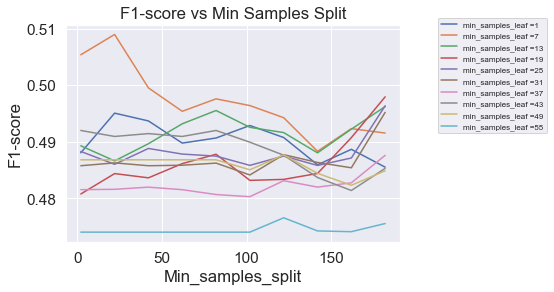

<Figure size 1080x576 with 0 Axes>

In [145]:
for i in min_samples_leaf_values:
    plt.plot(average_values_dt['Min_Samples_Split'][average_values_dt['Min_Samples_Leaf'] == i], average_values_dt['f1_score'][average_values_dt['Min_Samples_Leaf'] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

### Best hyperparameters: min_samples_split = 2,min_samples_leaf=1

In [146]:
average_values_dt[average_values_dt['f1_score'] == average_values_dt['f1_score'].max()]

,Min_Samples_Split,Min_Samples_Leaf,f1_score
11,22,7,0.508959


### Tuned Decision Tree Results

In [177]:
x_train_balanced, y_train_balanced = sm.fit_resample(x_train, y_train)
dt_tuned = DecisionTreeClassifier(min_samples_split = 22,min_samples_leaf=7).fit(x_train_balanced, y_train_balanced)
y_pred_dt_tuned = dt_tuned.predict(x_test)
print(f1_score(y_test, y_pred_dt_tuned, average = 'macro'))
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt_tuned)
conf_matrix_dt_percentage = [np.round(conf_matrix_dt[i]/sum(conf_matrix_dt[i])*100,0) for i in range(len(conf_matrix_dt))]
print("f1 score: ", f1_score(y_test, y_pred_dt_tuned, average = 'macro'))
conf_matrix_dt_percentage

0.47302786440028904
f1 score:  0.47302786440028904


[array([90., 10.,  0.]), array([52., 40.,  8.]), array([10., 67., 24.])]

Text(0.5,8.5,'Predicted')

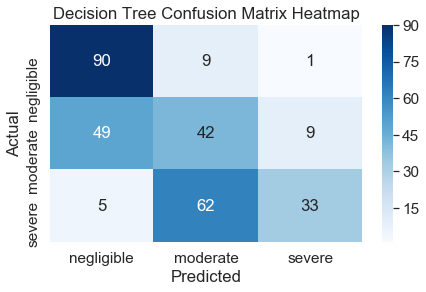

In [176]:
df_cm = pd.DataFrame(conf_matrix_dt_percentage, index = ['negligible','moderate','severe'], columns = ['negligible','moderate','severe'])
plt.figure(figsize = (7,4))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, cmap = plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix Heatmap")
plt.ylabel("Actual")
plt.xlabel("Predicted")

### Decision Tree Feature Importances

In [17]:
dict(zip(dt.feature_importances_,data_x.columns))

{0.016772740831862375: 'EVENT_ID',
 0.014673684823767361: 'median_income',
 0.0439455767894066: 'population_density',
 0.04319359178102938: 'housing_units_density',
 0.022547064715562348: 'duration',
 0.007210428353295293: 'weekend',
 0.021307138721897167: 'sin_time',
 0.02879465317005775: 'cos_time',
 0.0145510379723232: 'sin_date',
 0.0091680119818927: 'cos_date',
 0.35895911862884555: 'tornado_intensity',
 0.21011971039732497: 'tornado_area',
 0.012289362526296997: 'average_range',
 0.14531577635181658: 'minimum_range',
 0.029500257096135282: 'average_latitude',
 0.008787911279304303: 'average_longitude',
 0.01286393457918233: 'percent_land',
 0.0: 'multi_vortex'}

### Most important features are tornado_intensity', 'tornado_area' and  'minimum_range'.

### Random Forest Classifier

### Default Parameters

In [18]:
rf_default = RandomForestClassifier().fit(x_train_balanced, y_train_balanced)
y_pred_rf_default = rf_default.predict(x_test)
conf_matrix_rf_default = confusion_matrix(y_test, y_pred_rf_default)
conf_matrix_rf_percentage_default = [np.round(conf_matrix_rf_default[i]/sum(conf_matrix_rf_default[i])*100,0) for i in range(len(conf_matrix_rf_default))]
print("f1 score: ", f1_score(y_test, y_pred_rf_default, average = 'macro'))
conf_matrix_rf_default

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


f1 score:  0.5529094188168343


array([[2045,  110,    7],
       [  92,   56,   11],
       [   0,   12,    9]])

### Tuning on n_estimators and max_depth

In [17]:
estimators = [10,100,500,1000]
maxdepth = [None,20,40,60,80]
k = 3
plotting_data_dt = []
sm = SMOTE(sampling_strategy = 'not majority')
skf = StratifiedKFold(n_splits=3, random_state=0)
for train_index, test_index in skf.split(x_train, y_train):
    X_cv_train, X_cv_validate = pd.DataFrame(x_train).iloc[train_index], pd.DataFrame(x_train).iloc[test_index]
    Y_cv_train, Y_cv_validate = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]
    X_cv_train_balanced, Y_cv_train_balanced = sm.fit_resample(X_cv_train, Y_cv_train)
    for i in estimators:
        for j in maxdepth:
            dt = RandomForestClassifier(n_estimators = i, max_depth = j, min_samples_split = 22,min_samples_leaf=7).fit(X_cv_train_balanced, np.ravel(Y_cv_train_balanced))
            y_pred = dt.predict(X_cv_validate)
            row = [i ,j, f1_score(Y_cv_validate, y_pred, average = 'macro')]
            plotting_data_dt.append(row) 

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
plotting_data_dt

[[10, None, 0.5343236902341797],
 [10, 20, 0.5210471198634866],
 [10, 40, 0.5492869764032197],
 [10, 60, 0.5179707717210783],
 [10, 80, 0.5164749987378815],
 [100, None, 0.539429785734162],
 [100, 20, 0.5397869664794086],
 [100, 40, 0.5497509841612978],
 [100, 60, 0.5383083958067628],
 [100, 80, 0.5331985255771602],
 [500, None, 0.5444540519767498],
 [500, 20, 0.5399510733432685],
 [500, 40, 0.5581808512353539],
 [500, 60, 0.5514615603454714],
 [500, 80, 0.5471140099121219],
 [1000, None, 0.5444540519767498],
 [1000, 20, 0.5420495323550881],
 [1000, 40, 0.5438062728940141],
 [1000, 60, 0.5467870678247141],
 [1000, 80, 0.5438602070996882],
 [10, None, 0.5749049402066643],
 [10, 20, 0.5442703865318791],
 [10, 40, 0.5579208293591112],
 [10, 60, 0.5396065451504227],
 [10, 80, 0.549028965475391],
 [100, None, 0.5574969539881821],
 [100, 20, 0.571961010061969],
 [100, 40, 0.5883650194157449],
 [100, 60, 0.5543271209807872],
 [100, 80, 0.5694314277576406],
 [500, None, 0.5706194812060866],
 [

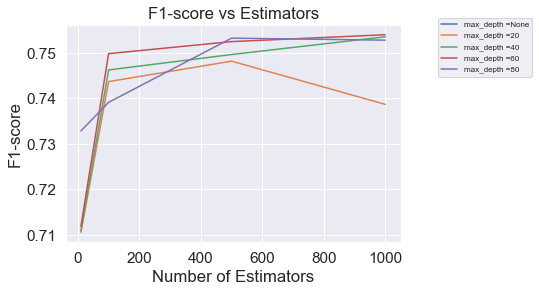

<Figure size 1080x576 with 0 Axes>

In [22]:
plotting_rf = pd.DataFrame(plotting_data_rf)
for i in maxdepth:
    plt.plot(plotting_rf[0][plotting_rf[1] == i], plotting_rf[2][plotting_rf[1] == i], label = "max_depth =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Estimators")
plt.ylabel("F1-score")
plt.xlabel("Number of Estimators")
plt.figure(figsize=(15,8))
plt.show()

### Best parameters -  n_estimators = 100, max_depth = 20

In [20]:
plotting_rf = pd.DataFrame(plotting_data_rf)
plotting_rf = plotting_rf.rename(columns={ 0: 'No of estimators', 1: 'Max Depth', 2: 'f1_score'})
plotting_rf[plotting_rf['f1_score'] == plotting_rf['f1_score'].max()]

,No of estimators,Max Depth,f1_score
15,1000,NaN,0.757508


In [26]:
rf_tuned = RandomForestClassifier(n_estimators = 1000, max_depth = None).fit(x_train_balanced, y_train_balanced)
y_pred_rf_tuned = rf_tuned.predict(x_test)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf_tuned)
conf_matrix_rf_percentage = [np.round(conf_matrix_rf[i]/sum(conf_matrix_rf[i])*100,0) for i in range(len(conf_matrix_rf))]
print("f1 score: ", f1_score(y_test, y_pred_rf_tuned, average = 'macro'))
conf_matrix_rf_percentage

f1 score:  0.5772156702397465


[array([95.,  5.,  0.]), array([55., 42.,  3.]), array([14., 52., 33.])]

Text(0.5,8.5,'Predicted')

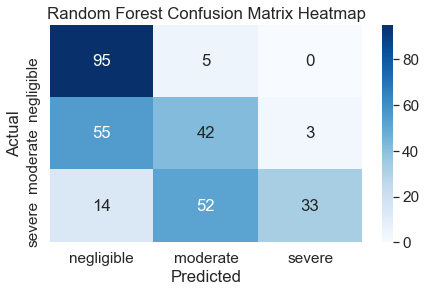

In [27]:
df_cm = pd.DataFrame(conf_matrix_rf_percentage, index = ['negligible','moderate','severe'], columns = ['negligible','moderate','severe'])
plt.figure(figsize = (7,4))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, cmap = plt.cm.Blues)
plt.title("Random Forest Confusion Matrix Heatmap")
plt.ylabel("Actual")
plt.xlabel("Predicted")

### Final Model

In [27]:
set(pd.read_csv('tornado-ytest.csv', header = None)[1])

{0.0, 1.0, 2.0}

In [7]:
test_set_y = pd.read_csv('tornado-ytest.csv', header = None)
test_set_x = pd.read_csv('tornado-xtest.csv')

In [8]:
sm = SMOTE(sampling_strategy = 'not majority')
x_train_balanced, y_train_balanced = sm.fit_resample(X, Y)

In [9]:
lr_final = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=200, C = pow(10,-4)).fit(x_train_balanced, y_train_balanced)
lr_pred_final = lr_final.predict(test_set_x)

lr_confusion = confusion_matrix(test_set_y[1], lr_pred_final)
lr_confusion_weighted = np.array([lr_confusion[i]/sum(lr_confusion[i])*100 for i in range(len(lr_confusion))])
lr_f1 = f1_score(test_set_y[1], lr_pred_final, average = 'macro')



print('Confusion Matrix\n'+str(lr_confusion))
print('\nConfusion Matrix with Weights\n'+str(lr_confusion_weighted))
print('\nF1 Score\n'+str(lr_f1))

Confusion Matrix
[[2702    0    0]
 [ 198    0    0]
 [  26    0    1]]

Confusion Matrix with Weights
[[100.          0.          0.       ]
 [100.          0.          0.       ]
 [ 96.2962963   0.          3.7037037]]

F1 Score
0.343875858801232


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5,8.5,'Predicted')

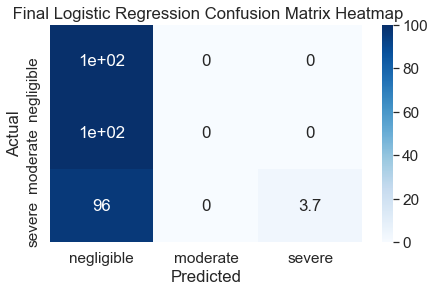

In [12]:
df_cm = pd.DataFrame(lr_confusion_weighted, index = ['negligible','moderate','severe'], columns = ['negligible','moderate','severe'])
plt.figure(figsize = (7,4))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, cmap = plt.cm.Blues)
plt.title(" Final Logistic Regression Confusion Matrix Heatmap")
plt.ylabel("Actual")
plt.xlabel("Predicted")